In [1]:
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf

In [2]:
def load_images_from_folder(folders):
    class_images = []
    for folder in folders:
        images = []
        for filename in os.listdir(folder):
            img = Image.open(os.path.join(folder,filename))
            if img is not None:
                img = img.resize((299, 299))
                images.append(np.array(img))
        class_images.append(images)
    
    return class_images.copy()

In [3]:
def defined_input(class_images):
    features = []
    for images in class_images:
        for img in images:
            features.append(img)
    features = np.array(features)
    features = tf.keras.applications.inception_v3.preprocess_input(features, data_format=None)
    return features

In [4]:
#เตรียม output
def defined_output(class_images):
    label = []
    for count, images in enumerate(class_images):
        for i in range(len(images)):
            classes = len(class_images)
            output = np.zeros((classes,), dtype=int)
            output[count] = 1
            label.append(output)
    return np.array(label)

In [5]:
#load test_data
foldersname = []
for i in range(14):
    foldersname.append('./images/Tail/test/class' + str(i)) #path_to_folder, change file path this.

class_images = load_images_from_folder(foldersname)

X_test = np.copy(defined_input(class_images))
y_test = np.copy(defined_output(class_images))

In [6]:
model_body = tf.keras.models.load_model('./model_latest/tail/tail_v1.h5') #path_to_model, change file path this.

In [7]:
prob = model_body.predict(X_test)

In [8]:
#get predicted class
y_pred = []
for p in prob:
    y_pred.append(np.argmax(p))
#get actual class
y_true = []
for y in y_test:
    y_true.append(np.argmax(y))

In [9]:
from sklearn.metrics import classification_report

target_names = []
for i in range(14):
    target_names.append('class' + str(i))
report = classification_report(y_true, y_pred, target_names = target_names)
print(report)

              precision    recall  f1-score   support

      class0       0.72      0.94      0.82        84
      class1       0.74      0.51      0.61        45
      class2       0.92      0.98      0.95        45
      class3       0.91      1.00      0.95        50
      class4       0.00      0.00      0.00         8
      class5       0.67      0.76      0.71        29
      class6       0.93      0.84      0.88        50
      class7       0.95      1.00      0.98        80
      class8       0.83      0.62      0.71        16
      class9       1.00      1.00      1.00        16
     class10       0.90      1.00      0.95        56
     class11       1.00      0.95      0.98        44
     class12       0.93      0.57      0.70        23
     class13       0.95      0.85      0.90        48

    accuracy                           0.87       594
   macro avg       0.82      0.79      0.80       594
weighted avg       0.87      0.87      0.86       594



C:\Users\acer\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
import pandas as pd 

#save report to excel
report_dict = classification_report(y_true, y_pred, target_names = target_names, output_dict=True)
df = pd.DataFrame(report_dict).transpose()
df.to_excel("tail_tail.xlsx")

# Threshold

In [ ]:
"""
Notes: วิธีในการหาค่า threshold ที่เหมาะสม 

link: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
"""

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score

def get_fpr_tpr_auc_threshold_for_class(y,y_pred,class_n):
    positive_class = []
    for pred in y_pred:
        positive_class.append(pred[class_n])
    positive_class = np.array(positive_class)
    new_y = []
    for i in y:
        if(np.argmax(i) == class_n):
            new_y.append(1)
        else:
            new_y.append(0)
    y = np.array(new_y)
    fpr, tpr, threshold = roc_curve(y, positive_class)
    auc = roc_auc_score(y,positive_class)
    fpr_tpr_auc_threshold = [fpr,tpr,auc,threshold]
    return fpr_tpr_auc_threshold

In [12]:
import matplotlib.pyplot as plt

def draw_graph(fpr_tpr_auc_threshold):
    count = 0
    plt.plot([0,1], [0,1], linestyle='--', label='Random prediction (AUROC = 0.500)')
    for i in fpr_tpr_auc_threshold:
        fpr = i[0]
        tpr = i[1]
        auc = i[2]
        plt.plot(fpr, tpr, linestyle='--', label='class '+str(count)+' prediction (AUROC = %0.3f)' % auc)
        count = count + 1
        
    # Title
    plt.title('ROC Plot')
    # Axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # Show legend
    plt.legend() # 
    # Show plot
    plt.show()

In [13]:
fpr_tpr_auc_threshold = []
for i in range(14): #predict 14 class
    fpr_tpr_auc_threshold.append(get_fpr_tpr_auc_threshold_for_class(y_test,prob,i))

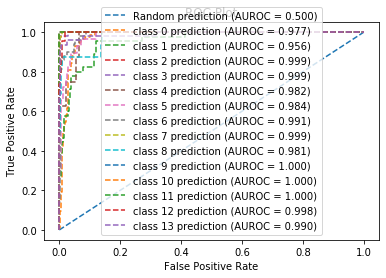

In [14]:
draw_graph(fpr_tpr_auc_threshold)

In [15]:
import math

count = 0
best_threshold = []
for i in fpr_tpr_auc_threshold:
    max = 0
    bt = 0
    for n in range(len(i[0])):
        if(math.sqrt(i[1][n] * (1-i[0][n])) > max): #i[1][n] - i[0][n]
            max = math.sqrt(i[1][n] * (1-i[0][n]))
            bt = i[3][n]
    best_threshold.append(bt)
    #next round
    bt = 0
    max = 0
    count = count + 1

In [16]:
print(best_threshold)

[0.28880477, 0.118895166, 0.3373567, 0.49555275, 0.03145171, 0.09121548, 0.19903487, 0.5067695, 0.16293563, 0.5732368, 0.5503075, 0.3024259, 0.09656057, 0.15812589]
